# Environmental Impact of Agricultural Practices in the World

**ADA Project Milestone 2**

This notebook consists of our initial Data Analysis of the FAOSTAT dataset on Food an agriculture. We will first study the contents of the data and its strucuture, before restructuring it in order to start our analysis. Also, some research questions initially asked will be answered by the end of this notebook.

## A. Initial Analysis

The dataset initially contained 78 csv files, but some of them were discarded as they will not be useful for our analysis. We have selected 43 CSVs that would help us with our analysis.

In [1]:
from glob import glob
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
csv_files = glob('data/**/**.csv')
len(csv_files)

43

We split those 43 csv into different directories, one for each group of csv. Each group corresponds to one category:
```.
+-- data/
|   +-- emissions_agriculture/
|      +-- ...
|   +-- emissions_land/
|      +-- ...
|   +-- environment/
|      +-- ...
|   +-- forestry/
|      +-- ...
|   +-- inputs/
|      +-- ...
|   +-- population/
|      +-- ...
|   +-- production/
|      +-- ...
```

---
### A.1 Schema consistency
---

We will first study the schemas of all the csv files we have in order to see if they are consistent or require changes

#### 1. Checking column names across whole dataset
---

Now, let's scan all the csv files and check their schemas.

In [1]:
from data_processing import scan_columns
all_columns = scan_columns(csv_files)
print("The found columns, grouped, are:\n")
for cols, f in all_columns:
    print(list(sorted(cols)), f"Num files {len(f)}")

NameError: name 'csv_files' is not defined

As we can see, sometimes the columns `area` and `areacode` are named `country` and `countrycode`, only because some csv files only contain country data, without country groups. We will rename those as to have a unified schema. Also, some files have the `note`, `elementgroup` and `months` columns. We will look into those in subsequent steps as we are now simply checking whether column naming is consistent.

In order to obtain a more consistent column naming, we will rename `country` to `area` and `countrycode` to `areacode`.

In [4]:
column_rename = {'country': 'area', 'countrycode': 'areacode'}

In [5]:
all_columns_2 = scan_columns(csv_files, column_rename)
print(f"After renaming, we obtain the following columns:\n")
for cols, f in all_columns_2:
    print(list(sorted(cols)), f"Num files {len(f)}")

After renaming, we obtain the following columns:

['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year', 'yearcode'] Num files 34
['area', 'areacode', 'element', 'elementcode', 'elementgroup', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 4
['area', 'areacode', 'element', 'elementcode', 'flag', 'months', 'monthscode', 'unit', 'value', 'year', 'yearcode'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'note', 'unit', 'value', 'year', 'yearcode'] Num files 4


#### 2. Checking which columns to drop
---

Now we have a few files that have different schemas. One column that we should look into before continuing is `note`, as it is in 4 files.

In [6]:
from data_processing import get_column_unique_values

files_with_note = all_columns_2[-1][1]
note_values = get_column_unique_values(files_with_note, column_rename, None,['note'])
note_values

,note
0,NaN


As we can see, all values for this column are NaN, so we can safely drop the column.

#### 3. Checking duplicate columns
---

We figured it would be useful to scan for duplicate columns in each dataframe (i.e. columns with different names but same values)

In [7]:
from data_processing import scan_column_duplicates
duplicates = scan_column_duplicates(csv_files, column_rename)
for c, f in duplicates:
    print(f"Duplicates for {c} in {len(f)} files")

Duplicates for [('yearcode', 'year')] in 39 files
Duplicates for [('elementgroup', 'elementcode')] in 3 files


As we can see, most files have `year` and `yearcode` columns which are equal. Hence, we can safely drop this column. However, for `elementgroup` and `elementcode`, they are equal in almost all CSV where they appear (3/4), but not all, so we cannot safely drop it without checking. We choose to keep `elementcode` when those two are equal, and keep them both when they are not.

Hence, we can define a list of columns to be checked and dropped; We drop them if they fulfill any of the following conditions:
 - NaN in all rows
 - Duplicate with another column

In [8]:
check_columns = ["note", "yearcode", "elementgroup"]
all_columns_3 = scan_columns(csv_files, column_rename, check_columns)
print(f"After renaming and dropping columns, we obtain the following columns:\n")
for cols, f in all_columns_3:
    print(list(sorted(cols)), f"Num files {len(f)}")

After renaming and dropping columns, we obtain the following columns:

['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 41
['area', 'areacode', 'element', 'elementcode', 'elementgroup', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'months', 'monthscode', 'unit', 'value', 'year'] Num files 1


We now have 41 files with identical schemas, and 2 files that have a different one:
 - The file containing the `elementgroup` additional column, which refers to groups of `elements`
 - The file with monthly data and no `item` and `itemcode` columns
 
To obtain the desired format, we can now call `load_dataframe(<file>, column_rename, drop_columns)` with `column_rename = {'country': 'area', 'countrycode': 'areacode'}` and `drop_columns = ["note", "yearcode", "elementgroup"]`

---
### A.2 Schema description

---
Now that we have a unified schema for (almost) all csv files, we can start looking into the meaning of each column and their possible value. 

#### 1. Area columns
---
We will first look into the columns `area` and `areacode`. According to FAOSTAT's website, each area is defined by a unique areacode, however some areas include other ones, i.e. there are grouped areas in the datasets. We would expect a one-to-one mapping between those two columns. Let's see how this looks like

To verify that it is indeed a one-to-one mapping, we will append all values from all csv files, and drop duplicates. Then we group by area and see if the length of the group is 1.

In [10]:
from utils import is_unique_mapping

area_values = get_column_unique_values(csv_files, column_rename, check_columns, ['area', 'areacode'])
is_unique_mapping(area_values, 'area', 'areacode')

False

It seems that the mapping is not one-to-one. Let's look into why that is. First we group by `areacode` and aggregate to a list of `area` and then we do the inverse. This way, we can see how the mapping is.

In [11]:
grpd = area_values.groupby('area')['areacode'].apply(list)
grpd[grpd.apply(lambda x: len(x) > 1)]

Series([], Name: areacode, dtype: object)

The mapping `area` -> `areacode` is unique, now for the opposite:

In [12]:
grpd = area_values.groupby('areacode')['area'].apply(list)
grpd[grpd.apply(lambda x: len(x) > 1)]

areacode
35                               [Cabo Verde, Cape Verde]
151     [Netherlands Antilles (former), Netherlands An...
154     [The former Yugoslav Republic of Macedonia, No...
167                             [Czechia, Czech Republic]
209                                 [Eswatini, Swaziland]
299           [Occupied Palestinian Territory, Palestine]
5000                             [World, World + (Total)]
5100                           [Africa, Africa + (Total)]
5101           [Eastern Africa, Eastern Africa + (Total)]
5102             [Middle Africa, Middle Africa + (Total)]
5103         [Northern Africa, Northern Africa + (Total)]
5104         [Southern Africa, Southern Africa + (Total)]
5105           [Western Africa, Western Africa + (Total)]
5200                       [Americas, Americas + (Total)]
5203       [Northern America, Northern America + (Total)]
5204         [Central America, Central America + (Total)]
5206                     [Caribbean, Caribbean + (Total)]
5207 

It seems that the same `areacode` is sometimes mapped to multiple `area`, most of the time by adding "+ (Total)". For that, we could drop the `area` column and keep working with `areacode`.

However, we still need a fixed database that maps the `areacode` to `area`, and for this, FAOSTAT provides one CSV file containing the mapping, as well as another one containing a description of country groups (i.e. "Asia") and which contries they contain.

In [14]:
from data_processing import load_dataframe
area_codes = load_dataframe('data/countries.csv')
area_codes.head()

,countrycode,country,m49code,iso2code,iso3code,startyear,endyear
0,2,Afghanistan,4.0,AF,AFG,NaN,NaN
1,5100,Africa,2.0,NaN,X06,NaN,NaN
2,284,Ã land Islands,248.0,NaN,ALA,NaN,NaN
3,3,Albania,8.0,AL,ALB,NaN,NaN
4,4,Algeria,12.0,DZ,DZA,NaN,NaN


In [15]:
country_groups = load_dataframe('data/country_groups.csv')
country_groups.head()

,countrygroupcode,countrygroup,countrycode,country,m49code,iso2code,iso3code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,24,British Indian Ocean Territory,86.0,IO,IOT


Here, countries are grouped into multiple `countrygroup`, so we know exactly of which countries each group is formed. These country groups are present in the dataset as `area`, meaning there are aggregated values in the dataset. For example: we can find the emissions for "Algeria" and for "Africa", where the latter is an aggregated value over the whole group. We will need to be careful when aggregating values in the future, as we could account multiple times for one country.

In [16]:
is_unique_mapping(area_codes[['country', 'countrycode']].drop_duplicates(), 'country', 'countrycode')

True

In [17]:
all(x in area_codes.countrycode.unique() for x in area_values.areacode.unique())

True

Hence, we can use the dataframe `area_codes` to obtain the country's name from it's code, and `country_groups` to get which countries form a group. For this, we can now drop the `area` column in our dataset.

#### 2. Element Columns
---

The `element` and `elementcode` represent the measure quantity for a given `item`. A quantity has a name and a unit, which is why we believe these two columns should also have a one-to-one mapping accross the whole dataset. Also, since an `elementcode` potentially uniquely identifies (`element`, `unit`) pair, we might drop those two columns as to make the csv files smaller and easier to manipulate.

First let's check if indeed this mapping is one-to-one:

In [18]:
element_values = get_column_unique_values(csv_files, column_rename, check_columns, ['elementcode', 'element', 'unit'])
is_unique_mapping(element_values, 'elementcode', ['element', 'unit'])

True

In [19]:
element_values.head()

,elementcode,element,unit
0,5111,Stocks,Head
171,5112,Stocks,1000 Head
684,5114,Stocks,No
0,5510,Production,tonnes
0,5313,Laying,1000 Head


As we can see, `elementcode` uniquely identify (`element`, `unit`) pairs, so we can safely drop those two columns and only use `elementcode`. We will later pivot each csv as to obtain all the `elementcode`s as columns, so we can reduce de number of rows significantly. A mapping using a dictionnary will of course be necessary in order to have a nice GUI where users can select the (element, unit) pair instead of the code.

#### 3. Item columns
---

According to FAOSTAT, the `item` and `itemcode` columns represent item on which measurements were done. For example an item can be `cattle` and the measurement can be "CH4 emissions in gigagrams". 
Similarly to what we did above, we expect `item` and `itemcode` to have a one-to-one relationship. Let's verify this using the same functions

In [20]:
item_values = get_column_unique_values(csv_files, column_rename, check_columns, ['item', 'itemcode'], with_file=True)
is_unique_mapping(item_values[['item', 'itemcode']], 'item', 'itemcode')

False

It seems that `item` to `itemcode` is not unique for a few items, let's check those and try to understand why it is the case.

In [21]:
grpd = item_values.groupby('itemcode')['item'].agg(set)
grpd[grpd.apply(len) > 1]

Series([], Name: item, dtype: object)

The mapping `itemcode` -> `item` is unique, now let's check the other way around

In [22]:
grouped = item_values.groupby('item')['itemcode'].agg(set)
grouped[grouped.apply(len) > 1]

item
Ammonium nitrate (AN)                                  {1362, 4003}
Ammonium sulphate                                      {1361, 4002}
Burning - all categories                               {6795, 6798}
Cattle                                                  {866, 1757}
Chickens                                               {1057, 1054}
Cropland                                               {6620, 5070}
Disinfectants                                          {1358, 1351}
Forest land                                      {5065, 6749, 6646}
Grassland                                              {6794, 6983}
Mineral Oils                                           {1354, 1316}
Other Pesticides nes                                   {1355, 1359}
Other nitrogenous fertilizers, n.e.c.                  {4008, 1369}
Other potassic fertilizers, n.e.c.                     {4018, 1391}
Plant Growth Regulators                                {1356, 1341}
Potassium sulphate (sulphate of potash) (SO

Some items seem to have multiple (up to 3) different item codes, which doesn't seem very normal. 

**a.** It seems that some of those items correspond to nutrients provided throught fertilizers. Let's see in which files those appear. The items related to nutrients are the following :

In [23]:
nutrient_items = ["Ammonium nitrate (AN)", "Ammonium sulphate", "Other nitrogenous fertilizers, n.e.c.", "Other potassic fertilizers, n.e.c.", "Potassium sulphate (sulphate of potash) (SOP)", "Urea"]
item_values[item_values.item.isin(nutrient_items)].file.unique()

array(['data/inputs/Inputs_FertilizersArchive_E_All_Data_(Normalized).csv',
       'data/inputs/Inputs_FertilizersProduct_E_All_Data_(Normalized).csv'],
      dtype=object)

Those items are only present in two dataframes, related to Ferilizer use. If we look closely at the names of csv files, we can see that one of them is "Archive", 
while the other is product. After having looking and reading the documentation for this CSV http://www.fao.org/faostat/en/#data/RA, we understand that it is an archive document, that has not been updated since 2002. 

Before that date, all data on Fertilizer was put into one single dataframe (i.e. info about production, trade and consumption) both in total nutrients and amount of product. After 2002, it was split into nutrient and product, which is why we have two `itemcode` values for those `items`. 

Hence, we should be careful when studying the fertilizer use, as data collection has changed in 2002.


**b.** Some items are related to pesticides. Let's in which csv files they appear

In [24]:
pesticide_items = ["Disinfectants", "Mineral Oils", "Other Pesticides nes", "Plant Growth Regulators"]
item_values[item_values.item.isin(pesticide_items)].file.unique()

array(['data/inputs/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv'],
      dtype=object)

Some duplicate items with the same name but different codes appear in only one csv file, which seems quite odd. We suspect having duplicate rows in that case. Let's check that out.

In [26]:
from data_processing import check_duplicate_items
t = load_dataframe('data/inputs/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv', column_rename, check_columns)
check_duplicate_items(t, pesticide_items)

Duplicate item for Disinfectants codes [1358 1351]
Duplicate item for Mineral Oils codes [1354 1316]
Duplicate item for Other Pesticides nes codes [1359 1355]
Duplicate item for Plant Growth Regulators codes [1356 1341]


We now know that there are potentially duplicate rows for the same `item` but a different `itemcode` (with the same measurements). Hence, we need to add a functionnality that checks for duplicated items in the dataframe.

**c.** Now let's look at livestock items

In [27]:
livestock_items = ["Cattle", "Chickens"]
item_values[item_values.item.isin(livestock_items)].groupby(['item', 'itemcode']).agg(set)

file
item     itemcode                                                   
Cattle   866       {data/production/Production_Livestock_E_All_Da...
         1757      {data/environment/Environment_LivestockManure_...
Chickens 1054      {data/emissions_agriculture/Emissions_Agricult...
         1057      {data/production/Production_Livestock_E_All_Da...

The `itemcode` -> `item` seems one-to-one in each csv file, but we see that there are two distinct `itemcode` for "Cattle" and "Chickens" accross all csv files.

In [28]:
item_values[item_values.item.isin(livestock_items)][['file', 'itemcode', 'item']].drop_duplicates().values

array([['data/production/Production_Livestock_E_All_Data_(Normalized).csv',
        866, 'Cattle'],
       ['data/production/Production_Livestock_E_All_Data_(Normalized).csv',
        1057, 'Chickens'],
       ['data/environment/Environment_LivestockPatterns_E_All_Data_(Normalized).csv',
        866, 'Cattle'],
       ['data/environment/Environment_LivestockPatterns_E_All_Data_(Normalized).csv',
        1057, 'Chickens'],
       ['data/environment/Environment_LivestockManure_E_All_Data_(Normalized).csv',
        1757, 'Cattle'],
       ['data/environment/Environment_LivestockManure_E_All_Data_(Normalized).csv',
        1054, 'Chickens'],
       ['data/emissions_agriculture/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Normalized).csv',
        1757, 'Cattle'],
       ['data/emissions_agriculture/Emissions_Agriculture_Manure_Management_E_All_Data_(Normalized).csv',
        1757, 'Cattle'],
       ['data/emissions_agriculture/Emissions_Agriculture_Manure_Management_E_All_Data_(N

It seems that different values for `itemcode` for both "Chickens" and "Cattles" differ when the measured quantity is realted to Manure. Thus, this might be a discrepancy in the data as it does not appear for other items. However, since the two different item codes appear in un-related csv files, we can keep them that way, and have two itemcodes that map to "Chickens" and "Cattle"

**d.** And finally, land related items

In [29]:
land_items = ["Forest land"]
item_values[item_values.item.isin(land_items)].sort_values(['item', 'file']).file.values

array(['data/emissions_land/Emissions_Land_Use_Forest_Land_E_All_Data_(Normalized).csv',
       'data/emissions_land/Emissions_Land_Use_Forest_Land_E_All_Data_(Normalized).csv',
       'data/emissions_land/Emissions_Land_Use_Land_Use_Total_E_All_Data_(Normalized).csv',
       'data/environment/Environment_LandUse_E_All_Data_(Normalized).csv',
       'data/inputs/Inputs_LandUse_E_All_Data_(Normalized).csv'],
      dtype=object)

After looking into the description of each csv file, we have found the following explanations:
- For `Burning - all categories`:
    - for "Emissions_Agriculture_Burning_Savanna_E_All_Data_(Normalized).csv", it represents the emissions due to burning of Savanna (all categories) i.e. aggregated over all items
    - for "Emissions_Land_Use_Burning_Biomass_E_All_Data_(Normalized).csv", it represents the emissions due to the burning of Biomass.
- For `Grassland`: 
    - for "Emissions_Agriculture_Burning_Savanna_E_All_Data_(Normalized).csv", it represents the emissions burning of grassland
    - for "Emissions_Land_Use_Land_Use_Total_E_All_Data_(Normalized).csv" it represents the Green house gass emissions and removals from grasslands
    - for "Environment_LandCover_E_All_Data_(Normalized).csv" it represents the area of grassland
- For `Cropland`:
    - for "Emissions_Land_Use_Land_Use_Total_E_All_Data_(Normalized).csv" it represents the Green house gass emissions and removals from Croplands
    - for "Environment_LandUse_E_All_Data_(Normalized).csv" it represents the area of Cropland
    - for "Inputs_LandUse_E_All_Data_(Normalized).csv" it represents the usage of Cropland
    
TODO : Add Forest Land, 

#### 4. Flag Columns
---

According to FAOSTAT, not all the data points are official figures reported by individual countries. Some are estimates, others are aggregates done by external entities. In order to understand the meaning of those flagas, they provide a csv file containing the description of each.

In [30]:
flags = load_dataframe("data/flags.csv")
flags.head()

,flag,flags
0,NaN,Official data
1,*,Unofficial figure
2,A,"Aggregate, may include official, semi-official..."
3,B,Balance
4,Bk,Break in series


In [31]:
print(f"There are {len(flags)} flags")

There are 41 flags


---
### A.3 Conclusion about Schemas

---

After having applied some analysis on the initially different schemas of the dataframes, we are now able to obtain identitcal schemas for 41 of them, and left two of them where we believe they should not be changed as some information could be lost.

The common schema has the following columns:

`['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year']`

For now, we have come up with a few steps that should be applied when loading a dataframe:
 - Rename columns to remove spaces and captial letters
 - Rename "Country" to "Area" and "CountryCode" to "Areacode"
 - Drop columns that are either duplicates or NaN values
 - Rename "gigagrams" to "Gigagrams", as otherwise we would have a non one-to-one mapping for `elementcode`
 - Check for items if they have duplicate rows.

The function that does the first 4 cleaning steps is `data_processing/load_dataframe`, and the one that puts everything together is `data_processing/load_clean_dataframe`.

Also, we have decided to only work with codes (i.e. `areacode` and `elementcode`) and drop `area`, `element` and `unit`. Of course, we will need a mapping from `code` -> `value`. Additionally, in order to keep track of `countrygroup` and do know how values are aggregated, we will also create a mapping that tells us which countries form a group, by codes.

Hence, to load a dataframe, we simply call :
```
df = load_clean_dataframe(<filename>, column_rename, check_columns, drop_columns)
```

with  `column_rename = {'country': 'area', 'countrycode': 'areacode'}` and `check_columns = ["note", "yearcode", "elementgroup"]` and `drop_columns = ["area", "item", "element", "unit"]`

In [3]:
column_rename = {'country': 'area', 'countrycode': 'areacode'}
check_columns = ["note", "yearcode", "elementgroup"]
drop_columns = ["area", "item", "element", "unit"]

Now we need to get the mappings for :
- `elementcode` -> (`element`, `unit`) (unique in both ways)
- `itemcode` -> `item` (unique in that way, but not the other way around)
- `areacode` -> `area` (unique in both ways)

In [24]:
from mappings import get_mapping, get_area_mapping, get_country_groups
item_mapping = get_mapping(csv_files, column_rename, check_columns, ['itemcode','item'])
element_mapping = get_mapping(csv_files, column_rename, check_columns, ['elementcode', 'element', 'unit'])


In [4]:
from mappings import get_area_mapping, get_country_groups
area_mapping = get_area_mapping("data/countries.csv")
country_groups = get_country_groups("data/country_groups.csv")

---
---
## B. Reshaping the Database

For now everything was stored in database format (i.e. Row format), but we would like to have elements in columns, so that we can reduce drastically the number of rows, and so we can have all the measurements for a single (`itemcode`, `areacode`, `year`) pair.

---
### B.1 Merging all files with same schema

---

Before reshaping, we know that 41 csv files have the same schema. Thus, it would be good to have them all in a single dataframe in order to facilitate access to values. We will then create a single dataframe from all those 41 (over 43 in total). This dataframe will then have potentially duplicate rows, which we will drop.

In [5]:
from data_processing import load_clean_dataframe
def load_all_df_with_schema(files, schema):
    dfs = []
    for f in csv_files:
        df = load_clean_dataframe(f, column_rename, check_columns, drop_columns) # Load the DF
        if all(x in schema for x in df.columns):  # Check if schema corresponds
            df = df.assign(file=f)
            dfs.append(df)
    df = pd.concat(dfs).reset_index(drop=True)
    shape = df.shape[0]
    
    to_keep = df.drop(columns=['file']).drop_duplicates().index # Drop all duplicated row, after removing `file`
    df = df.loc[to_keep].reset_index(drop=True)
    print(f"Dropped {shape - df.shape[0]} duplicate rows")
    return df

In [6]:
df = load_all_df_with_schema(csv_files, ['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'])

Dropped duplicate item Disinfectants with codes [1358, 1351] (Dropped 1351)
Dropped duplicate item Mineral Oils with codes [1354, 1316] (Dropped 1316)
Dropped duplicate item Other Pesticides nes with codes [1359, 1355] (Dropped 1355)
Dropped duplicate item Plant Growth Regulators with codes [1356, 1341] (Dropped 1341)
Dropped 1919040 duplicate rows


In [7]:
group_codes = set(country_groups.keys())
df = df[~df.areacode.isin(group_codes)]#.reset_index(drop=True)  # Drop all country groups

In [8]:
import gc
gc.collect()

44

---
### B.2 Checking for duplicate measurements

---

Ideally, we would like to have a single row for each (`areacode`, `itemcode`, `elementcode` and `year`), i.e one measurement. Let's check if it is the case:

In [10]:
grouped = df.groupby(['areacode', 'itemcode', 'elementcode', 'year'])[['value', 'flag']].nunique(dropna=False).reset_index()
grouped['value'].value_counts(dropna=False) / grouped.shape[0]

1    0.964959
2    0.035041
Name: value, dtype: float64

As we can see, it is not the case:
    - Most of the time there is one measurement (~96%)
    - Some have two measurements (~4%)
This could be due to different `value` and/or different `flag`

Let's look at those values

#### 1. Assessing Elements that have duplicates

In order to remediate to this issue, we will look at the differences between the values, when there are multiple ones, and group by `elementcode`

In [14]:
from utils import get_percentage_diff

def get_discrepancies(df):
    indexed = df.set_index(['areacode', 'itemcode', 'elementcode', 'year']) # Set the index to what what should be unique
    duplicated_1 = indexed.index.duplicated(keep='first')  # Take the first duplicate
    duplicated_2 = indexed.index.duplicated(keep='last')  # Take the second one
    joined = indexed.loc[duplicated_1].join(indexed.loc[duplicated_2], rsuffix='_2')  # Join on the index to have both values and indices
    return joined

def get_discrepancies_by_elem(df, e_mapping):
    discrepancies_by_element = df.reset_index().groupby('elementcode')\
                                 .apply(lambda x: pd.Series({'mean_diff': np.mean(x['value'] - x['value_2']), # Mean difference
                                                             'std': np.std(x['value'] - x['value_2']),        # STD of difference
                                                             'csv': set(tuple(i) for i in x[['file', 'file_2']].values.tolist()),  # CSV files where there are different values
                                                             'num': x.shape[0],                                 # Number of different values
                                                             'mean_perc_diff': np.mean(get_percentage_diff(x['value'], x['value_2'])*100)})) # Average difference in percentage
    discrepancies_by_element.index = [e_mapping[i] for i in discrepancies_by_element.index]
    return discrepancies_by_element

In [12]:
joined = get_discrepancies(df)

In [13]:
discrepancies_by_element = get_discrepancies_by_elem(joined, element_mapping).sort_values('std')
discrepancies_by_element

,mean_diff,std,csv,num,mean_perc_diff
"(Area, 1000 ha)",0.000000e+00,0.000000,{(data/inputs/Inputs_LandUse_E_All_Data_(Norma...,6290,0.000000e+00
"(Manure applied to soils that volatilises (N content), kg)",8.568984e-07,0.000030,{(data/emissions_agriculture/Emissions_Agricul...,119694,3.091777e-05
"(Manure applied to soils that leaches (N content), kg)",-1.824625e-07,0.000031,{(data/emissions_agriculture/Emissions_Agricul...,127883,2.061410e-05
"(Manure applied to soils (N content), kg)",7.303738e-07,0.000031,{(data/emissions_agriculture/Emissions_Agricul...,98108,5.130522e-06
"(Manure left on pasture that volatilises (N content), kg)",1.336092e-06,0.000031,{(data/emissions_agriculture/Emissions_Agricul...,77879,8.938878e-06
"(Manure left on pasture that leaches (N content), kg)",-4.747674e-07,0.000032,{(data/emissions_agriculture/Emissions_Agricul...,88475,6.441224e-06
"(Manure treated (N content), kg)",8.953654e-07,0.000033,{(data/emissions_agriculture/Emissions_Agricul...,49992,9.461075e-06
"(Manure left on pasture (N content), kg)",-5.481813e-07,0.000033,{(data/emissions_agriculture/Emissions_Agricul...,55120,1.751645e-06
"(Area, ha)",4.840766e-05,0.000242,{(data/emissions_agriculture/Emissions_Agricul...,157,1.362119e-07
"(Stocks, Head)",-5.714286e-02,0.998366,{(data/environment/Environment_LivestockManure...,70,5.809386e-03


As we can see, most differences have a very small mean and standard deviation, with a small percentage in variation. However, the last 4 elements have quite high differences in the two values, and we would like to see why that is.

For this, let's print the csv files that have conflicting values:

In [14]:
for i, f in discrepancies_by_element[-4:][['csv']].iterrows():
    print(f"Discrepancies in {i} are in \n")
    for c in f.csv:
        print(c)
    print("\n")

Discrepancies in ('Emissions (CO2eq) from N2O', 'Gigagrams') are in 

('data/emissions_agriculture/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).csv', 'data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv')
('data/emissions_land/Emissions_Land_Use_Land_Use_Total_E_All_Data_(Normalized).csv', 'data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv')


Discrepancies in ('Emissions (CO2eq)', 'Gigagrams') are in 

('data/emissions_agriculture/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).csv', 'data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv')


Discrepancies in ('Emissions (CO2eq) from CH4', 'Gigagrams') are in 

('data/emissions_agriculture/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).csv', 'data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv')
('data/emissions_land/Emissions_Land_Use_Land_Use_Total_E_All_Data_(Normalized).csv', 'data/

As we can see, large differences in values are found when using the csvs `data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv`, and `data/environment/Environment_Emissions_intensities_E_All_Data_(Normalized).csv`, as well as "Processed" version of `data/production/Production_Crops_E_All_Data_(Normalized).csv` (which means the emissions due to processed Crops).

Since we want to focus only on the general view of production, we will then drop the two csv that account for Production for Processed crops and livestock (i.e. derived products from crops and livestock).

Also, the emissions by sector are computed differently than the emissions for each sector individually (according to FAO), which are more accurate as they are aggregates of more specific items. For this reason, we have also decided to drop `data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv` and `data/environment/Environment_Emissions_intensities_E_All_Data_(Normalized).csv`, the latter because it only contains indicators rather that raw values.

In [9]:
csv_to_drop = ["data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv", 
               "data/environment/Environment_Emissions_intensities_E_All_Data_(Normalized).csv", 
               "data/production/Production_CropsProcessed_E_All_Data_(Normalized).csv", 
               "data/production/Production_LivestockProcessed_E_All_Data_(Normalized).csv"]
df = df[~df.file.isin(csv_to_drop)]

In [15]:
joined = get_discrepancies(df)

In [16]:
discrepancies_2 = get_discrepancies_by_elem(joined, element_mapping)
discrepancies_2.sort_values('std')

,mean_diff,std,csv,num,mean_perc_diff
"(Area, 1000 ha)",0.000000e+00,0.000000,{(data/inputs/Inputs_LandUse_E_All_Data_(Norma...,6290,0.000000e+00
"(Manure applied to soils that volatilises (N content), kg)",8.568984e-07,0.000030,{(data/emissions_agriculture/Emissions_Agricul...,119694,3.091777e-05
"(Manure applied to soils that leaches (N content), kg)",-1.824625e-07,0.000031,{(data/emissions_agriculture/Emissions_Agricul...,127883,2.061410e-05
"(Manure applied to soils (N content), kg)",7.303738e-07,0.000031,{(data/emissions_agriculture/Emissions_Agricul...,98108,5.130522e-06
"(Manure left on pasture that volatilises (N content), kg)",1.336092e-06,0.000031,{(data/emissions_agriculture/Emissions_Agricul...,77879,8.938878e-06
"(Manure left on pasture that leaches (N content), kg)",-4.747674e-07,0.000032,{(data/emissions_agriculture/Emissions_Agricul...,88475,6.441224e-06
"(Manure treated (N content), kg)",8.953654e-07,0.000033,{(data/emissions_agriculture/Emissions_Agricul...,49992,9.461075e-06
"(Manure left on pasture (N content), kg)",-5.481813e-07,0.000033,{(data/emissions_agriculture/Emissions_Agricul...,55120,1.751645e-06
"(Area, ha)",4.840766e-05,0.000242,{(data/emissions_agriculture/Emissions_Agricul...,157,1.362119e-07
"(Stocks, Head)",-5.714286e-02,0.998366,{(data/environment/Environment_LivestockManure...,70,5.809386e-03


Now, the discrepancies have very low variance, and hence, we can safely drop some duplicate rows according to a rule using the `value` and `flag`

#### 2. Taking care of duplicate measurements

Now that we have understood where the big differences in duplicates appear, we focus on those that are still here, but are quite small. In order to get rid of duplicate measurements, we will work with a combination of the `value` and `flag` columns.

In [17]:
def is_close(value_1, value_2, threshold=0.01):
    diff = get_percentage_diff(value_1, value_2)
    return (value_1 == value_2) | (diff < threshold) | (value_1.isna() & value_2.isna())

def is_same_flag(flag_1, flag_2):
    return (flag_1 == flag_2) | (flag_1.isna() & flag_2.isna())

In [19]:
if all(is_close(joined['value'], joined['value_2'])):
    print("All duplicated measruements' difference are at less than 1%")

All duplicated measruements' difference are at less than 1%


In [20]:
same_flag = joined[is_same_flag(joined.flag, joined.flag_2)]
print("{:.2f}% of duplicated rows have the same flag".format(same_flag.shape[0]/ joined.shape[0]*100))

98.98% of duplicated rows have the same flag


Since most duplicated measurements'values are really close, we will take the mean if there are two different values.

In [10]:
df = df.drop(columns=['file', 'flag']).drop_duplicates().groupby(['areacode', 'itemcode', 'elementcode', 'year'])['value'].mean().reset_index()

In [33]:
df

NameError: name 'df' is not defined

---
### B.3 Reshaping measurements as columns
---

Now that we have unique measurements, we will reshape the dataframe to put each measurement for an item as column, so that for each (`areacode`, `itemcode`, `year`) we have all the measurements as columns.

In [12]:
reshaped_df = df.set_index(['areacode', 'itemcode', 'elementcode', 'year'])['value'].unstack(level=2).reset_index()

In [16]:
reshaped_df.to_pickle("data/reshaped_df.pkl")

In [111]:
from utils import get_item
cattle = get_item(reshaped_df, 867, areacodes=[21,231])

In [112]:
cattle.head()

elementcode,areacode,itemcode,year,5320,5417,5510
243140,21,867,1961,7141000.0,1917.0,1369078.0
243141,21,867,1962,6989000.0,1940.0,1355958.0
243142,21,867,1963,7065000.0,1926.0,1360928.0
243143,21,867,1964,7523000.0,1910.0,1437185.0
243144,21,867,1965,7843000.0,1909.0,1496849.0


In [113]:
from sklearn.linear_model import LinearRegression
ls = LinearRegression(fit_intercept=True, normalize=True)

In [114]:
element_mapping[5510], item_mapping[867]

(('Production', 'tonnes'), 'Meat, cattle')

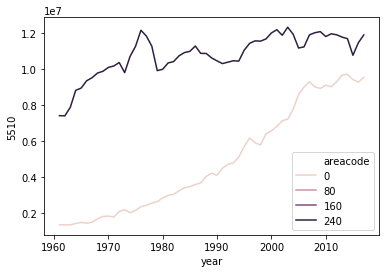

In [116]:
sns.lineplot(x=cattle.year, y=cattle[5510], hue="areacode", data=cattle, )

In [117]:
cattle.areacode.unique()

array([ 21, 231])

In [101]:
area_mapping

{2: 'Afghanistan',
 5100: 'Africa',
 284: 'Ã\x85land Islands',
 3: 'Albania',
 4: 'Algeria',
 5: 'American Samoa',
 5200: 'Americas',
 6: 'Andorra',
 7: 'Angola',
 258: 'Anguilla',
 5848: 'Annex I countries',
 5600: 'Antarctic Region',
 30: 'Antarctica',
 8: 'Antigua and Barbuda',
 9: 'Argentina',
 1: 'Armenia',
 22: 'Aruba',
 5300: 'Asia',
 10: 'Australia',
 5501: 'Australia and New Zealand',
 11: 'Austria',
 52: 'Azerbaijan',
 12: 'Bahamas',
 13: 'Bahrain',
 16: 'Bangladesh',
 14: 'Barbados',
 57: 'Belarus',
 255: 'Belgium',
 15: 'Belgium-Luxembourg',
 23: 'Belize',
 53: 'Benin',
 17: 'Bermuda',
 18: 'Bhutan',
 19: 'Bolivia (Plurinational State of)',
 278: 'Bonaire, Sint Eustatius and Saba',
 80: 'Bosnia and Herzegovina',
 20: 'Botswana',
 31: 'Bouvet Island',
 21: 'Brazil',
 24: 'British Indian Ocean Territory',
 239: 'British Virgin Islands',
 26: 'Brunei Darussalam',
 27: 'Bulgaria',
 233: 'Burkina Faso',
 29: 'Burundi',
 35: 'Cabo Verde',
 115: 'Cambodia',
 32: 'Cameroon',
 33: '

In [65]:
ls = ls.fit(X=cattle[5111].values.reshape(-1,1)[:-100], y=cattle[72254][:-100])

In [66]:
pred = ls.predict(cattle[5111].values.reshape(-1, 1)[-100:])

In [67]:
err = pred - cattle[72254][-100:].values

In [73]:
import seaborn as sns

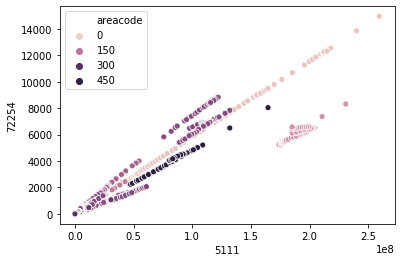

In [84]:
sns.scatterplot(x=cattle[5111], y=cattle[72254], hue=cattle.areacode)

In [82]:
cattle["5111"]

KeyError: '5111'

In [80]:
cattle.areacode.unique()

array([  1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  23,  25,  26,  27,  28,  29,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  72,  73,  74,
        75,  79,  80,  81,  84,  85,  86,  87,  88,  89,  90,  91,  93,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 129, 130, 131, 133, 134, 135, 136, 137,
       138, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168,
       169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 21